# Libraries

In [1]:
from matplotlib.pylab import *
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection
from matplotlib.lines import Line2D
import torch
import torch.nn as nn
from torch.optim import SGD
from torchviz import make_dot
from tqdm import tqdm
from datetime import datetime
from random import uniform
import wandb

num_lessons = 10
current_time = datetime.now().strftime("%Y-%m-%d_%I-%M%p")
π = pi
style.use(['dark_background', 'bmh'])
%matplotlib widget

![car-trailer](figures/truck-backer-upper.png)


\begin{align}
\dot x &= s \cos \theta_0 \\
\dot y &= s \sin \theta_0 \\
\dot \theta_0 &= \frac{s}{L} \tan \phi \\
\dot \theta_1 &= \frac{s}{d_1} \sin(\theta_1 - \theta_0)
\end{align}

# Preparing Lessons

In [2]:
def create_lesson_configs(num_lessons):
    configs = {}

    first_lesson = {"θ0_range": (0, 10),
                    "Δθ1_range": (-10, 10),
                    "x_range": (10, 10),
                    "y_range": (-2, 2)}
    
    final_lesson = {"θ0_range": (0, 120),
                    "Δθ1_range": (-45, 45),
                    "x_range": (10, 35),
                    "y_range": (-7, 7)}

    x_min = first_lesson["x_range"][0]

    for i in range(1, num_lessons + 1):

        θ0_max = first_lesson["θ0_range"][1] + (final_lesson["θ0_range"][1] - 
                                                first_lesson["θ0_range"][1]) * (i - 1) // (num_lessons - 1)
        
        Δθ1_max = first_lesson["Δθ1_range"][1] + (final_lesson["Δθ1_range"][1] - 
                                                  first_lesson["Δθ1_range"][1]) * (i - 1) // (num_lessons - 1)
        
        x_max = first_lesson["x_range"][1] + (final_lesson["x_range"][1] - 
                                              first_lesson["x_range"][1]) * (i - 1) // (num_lessons - 1)
        
        y_max = first_lesson["y_range"][1] + (final_lesson["y_range"][1] - 
                                              first_lesson["y_range"][1]) * (i - 1) // (num_lessons - 1)

        configs[i] = {"θ0_range": (0, θ0_max),
                      "Δθ1_range": (-Δθ1_max, Δθ1_max),
                      "x_range": (x_min, x_max),
                      "y_range": (-y_max, y_max)}
        x_min = x_max
        
    configs[num_lessons+1] = final_lesson
    return configs

LESSON_CONFIGS = create_lesson_configs(num_lessons)

# Initializing Truck

In [3]:
class Truck:
    def __init__(self, lesson, display=False):

        self.W = 1 
        self.L = 1 * self.W 
        self.d = 4 * self.L 
        self.s = -0.1
        self.display = display
        self.lesson = lesson
        
        self.box = [0, 40, -10, 10]
        if self.display:
            self.f = figure(figsize=(6, 3), num='The Truck Backer-Upper', facecolor='none')
            self.ax = self.f.add_axes([0.01, 0.01, 0.98, 0.98], facecolor='black')
            self.patches = list()
            
            self.ax.axis('equal')
            b = self.box
            self.ax.axis([b[0] - 1, b[1], b[2], b[3]])
            self.ax.set_xticks([]); self.ax.set_yticks([])
            self.ax.axhline(); self.ax.axvline()
            
    def reset(self, ϕ=0):
        self.ϕ = ϕ 
        config = LESSON_CONFIGS.get(self.lesson)
        
        if config is None: 
            raise ValueError(f"No configuration found for lesson {self.lesson}")       
            
        self.θ0 = deg2rad(uniform(*config["θ0_range"]))
        self.θ1 = deg2rad(uniform(*config["Δθ1_range"])) + self.θ0
        self.x = uniform(*config["x_range"])
        self.y = uniform(*config["y_range"])      
        
        # If poorly initialise, then re-initialise
        if not self.valid():
            self.reset(ϕ)
        
        # Draw, if display is True
        if self.display: 
            self.draw()        
    
    def step(self, ϕ=0, dt=1):
        
        # Check for illegal conditions
        if self.is_jackknifed():
            print('The truck is jackknifed!')
            return
        
        if self.is_offscreen():
            print('The car or trailer is off screen')
            return
        
        self.ϕ = ϕ
        x, y, W, L, d, s, θ0, θ1, ϕ = self._get_atributes()
        
        # Perform state update
        self.x += s * cos(θ0) * dt
        self.y += s * sin(θ0) * dt
        self.θ0 += s / L * tan(ϕ) * dt
        self.θ1 += s / d * sin(θ0 - θ1) * dt   
                        
        return (self.x, self.y, self.θ0, *self._trailer_xy(), self.θ1)
    
    def state(self):
        return (self.x, self.y, self.θ0, *self._trailer_xy(), self.θ1)
    
    def _get_atributes(self):
        return (
            self.x, self.y, self.W, self.L, self.d, self.s,
            self.θ0, self.θ1, self.ϕ
        )
    
    def _trailer_xy(self):
        x, y, W, L, d, s, θ0, θ1, ϕ = self._get_atributes()
        return x - d * cos(θ1), y - d * sin(θ1)
        
    def is_jackknifed(self):
        x, y, W, L, d, s, θ0, θ1, ϕ = self._get_atributes()
        angle_diff_rad = abs(θ0 - θ1)
        angle_diff_deg = rad2deg(angle_diff_rad)
        return angle_diff_deg > 90
    
    def is_offscreen(self):
        x, y, W, L, d, s, θ0, θ1, ϕ = self._get_atributes()
        
        x1, y1 = x + 1.5 * L * cos(θ0), y + 1.5 * L * sin(θ0)
        x2, y2 = self._trailer_xy()
        
        b = self.box
        return not (
            b[0] <= x1 <= b[1] and b[2] <= y1 <= b[3] and
            b[0] <= x2 <= b[1] and b[2] <= y2 <= b[3]
        )
        
    def valid(self):
        return not self.is_jackknifed() and not self.is_offscreen()
        
    def draw(self):
        if not self.display: return
        if self.patches: self.clear()
        self._draw_car()
        self._draw_trailer()
        self.f.canvas.draw()
            
    def clear(self):
        for p in self.patches:
            p.remove()
        self.patches = list()
        
    def _draw_car(self):
        x, y, W, L, d, s, θ0, θ1, ϕ = self._get_atributes()

        ax = self.ax
        
        x1, y1 = x + L / 2 * cos(θ0), y + L / 2 * sin(θ0)
        bar = Line2D((x, x1), (y, y1), lw=5, color='C2', alpha=1)
        ax.add_line(bar)

        car = Rectangle((x1, y1 - W / 2),   
                        L,                  
                        W,                  
                        color='C2',        
                        alpha=1,
                        transform=(matplotlib.transforms.Affine2D().rotate_deg_around(x1, y1, rad2deg(θ0)) +
                                   ax.transData))

        ax.add_patch(car)

        x2, y2 = x1 + L / 2 ** 0.5 * cos(θ0 + π / 4), y1 + L / 2 ** 0.5 * sin(θ0 + π / 4)
        left_wheel = Line2D(
            (x2 - L / 4 * cos(θ0 + ϕ), x2 + L / 4 * cos(θ0 + ϕ)),
            (y2 - L / 4 * sin(θ0 + ϕ), y2 + L / 4 * sin(θ0 + ϕ)),
            lw=3, color='C5', alpha=1)
        ax.add_line(left_wheel)

        x3, y3 = x1 + L / 2 ** 0.5 * cos(π / 4 - θ0), y1 - L / 2 ** 0.5 * sin(π / 4 - θ0)
        right_wheel = Line2D(
            (x3 - L / 4 * cos(θ0 + ϕ), x3 + L / 4 * cos(θ0 + ϕ)),
            (y3 - L / 4 * sin(θ0 + ϕ), y3 + L / 4 * sin(θ0 + ϕ)),
            lw=3, color='C5', alpha=1)
        ax.add_line(right_wheel)
        
        self.patches += [car, bar, left_wheel, right_wheel]
        
    def _draw_trailer(self):
        x, y, W, L, d, s, θ0, θ1, ϕ = self._get_atributes()    
        ax = self.ax
             
        x, y = x - d * cos(θ1), y - d * sin(θ1) - W / 2
        trailer = Rectangle((x, y),   
                            d,        
                            W,        
                            color='C0', 
                            alpha=1,
                            transform = (matplotlib.transforms.Affine2D().rotate_deg_around(x, y + W / 2, rad2deg(θ1)) + 
                                         ax.transData))

        ax.add_patch(trailer)
        
        self.patches += [trailer]
        
    def update_state(self, state): 
        self.ϕ, self.x, self.y, self.θ0, _, _, self.θ1 = state.tolist()

# Defining Functions to Train Emulator and Controller

In [4]:
def generate_random_deg(mean, std, scale_lower, scale_upper): 
    random_num = np.random.normal(loc = mean, scale = std)
    random_num_scaled = np.clip(random_num, scale_lower, scale_upper)
    return random_num_scaled

In [5]:
def initialize_emulator(): 
    emulator = nn.Sequential(
        nn.Linear(7, 100),
        nn.GELU(),
        nn.Linear(100, 100),
        nn.GELU(),
        nn.Linear(100, 6)
    )

    torch.save(emulator, 'models/emulators/emulator_lesson_0.pth')
    return emulator


def initialize_controller():
    controller = nn.Sequential( 
        nn.Linear(7, 50),
        nn.Tanh(),
        nn.Linear(50, 1)
    )
          
    torch.save(controller, 'models/controllers/controller_lesson_0.pth')
    return controller

In [6]:
criterion_emulator = nn.MSELoss()  

def criterion_controller(ϕ_state, step):
    _, _, _, θ0, x, y, θ1 = ϕ_state 
    angle_diff_rad = torch.abs(θ1 - θ0)
    angle_diff_deg = torch.rad2deg(angle_diff_rad)
    angle_diff_relu = nn.functional.relu((angle_diff_deg - 30)/30)
    x_relu = nn.functional.relu(x)
    min_θ1 = torch.min(torch.abs(θ1), torch.abs(torch.abs(θ1) - torch.deg2rad(torch.tensor(360.0))))
    part1 = x_relu + torch.abs(y) + min_θ1
    part2 = (x_relu**2 + y**2 + min_θ1**2 + angle_diff_relu**2 + step * 0.01)
    return -torch.log(1 / (part1 * part2))

In [7]:
def train_emulator(emulator, 
                   episodes, 
                   learning_rate, 
                   lesson, 
                   wandb_log = False):
    
    if wandb_log:
        wandb.init(project='emulator-training', save_code = True, name=f'lesson_{lesson}_run_{current_time}')
        
    inputs = list()
    outputs = list()
    truck = Truck(lesson)
    for episode in tqdm(range(episodes)):
        truck.reset()
        while truck.valid():
            initial_state = truck.state()
            random_deg = generate_random_deg(mean = 0, 
                                             std = 35, 
                                             scale_lower = -70, 
                                             scale_upper = 70)
            ϕ = deg2rad(random_deg)
            inputs.append((ϕ, *initial_state))
            outputs.append(truck.step(ϕ))
            
    tensor_inputs = torch.Tensor(inputs)
    tensor_outputs = torch.Tensor(outputs)
    
    test_size = int(len(tensor_inputs) * 0.8)
    
    train_inputs = tensor_inputs[:test_size]
    train_outputs = tensor_outputs[:test_size]
    
    test_inputs = tensor_inputs[test_size:]
    test_outputs = tensor_outputs[test_size:]
    
    print("Train Size:", len(train_inputs))
    print("Test Size:", len(test_inputs))
    
    optimizer = torch.optim.Adam(emulator.parameters(), lr=learning_rate)
    
    global_step = 0
    for i in torch.randperm(len(train_inputs)):
        ϕ_state = train_inputs[i]
        
        next_state_prediction = emulator(ϕ_state)
        next_state = train_outputs[i]
        
        optimizer.zero_grad()
        
        loss = criterion_emulator(next_state_prediction, next_state)
        loss.backward()
        
        if wandb_log:
            wandb.log({'train_loss': loss.item(),
                       'gradients': {name: param.grad.norm().item() for name, param in emulator.named_parameters() if param.grad is not None}}, step=global_step)
        
        optimizer.step()
        global_step += 1

    with torch.no_grad():
        total_loss = 0
        for j in range(len(test_inputs)):
            ϕ_state = test_inputs[j]
            next_state = test_outputs[j]
            
            next_state_prediction = emulator(ϕ_state)
            
            loss = criterion_emulator(next_state_prediction, next_state)
            total_loss += loss.item()
            
            if wandb_log:
                wandb.log({'test_loss': loss.item()}, step = global_step)
                
            global_step += 1

    test_size = len(test_inputs)
    avg_test_loss = total_loss / test_size
    
    print()
    print(f'Test loss: {avg_test_loss:.10f}')
    
    torch.save(emulator, f'models/emulators/emulator_lesson_{lesson}.pth')
    
    if wandb_log:
        wandb.finish()
    
    return emulator

In [8]:
def train_controller(lesson, 
                     controller, 
                     epochs, 
                     max_steps,
                     wandb_log = False,
                     save_computational_graph = False,
                     learning_rate = 0.0001):
      
    if wandb_log: 
        wandb.init(project='controller-training', save_code = True, name=f'lesson_{lesson}_run_{current_time}')
      
    emulator = torch.load('models/emulators/emulator_lesson_{}.pth'.format(lesson), weights_only=False)
    optimizer = torch.optim.Adam(controller.parameters(), lr=learning_rate, weight_decay=0.0001)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1000, gamma=0.9)
    truck = Truck(lesson, display=False)
    
    for i in tqdm(range(epochs)):
        truck.reset()
        random_deg = generate_random_deg(mean = 0, 
                                         std = 70, 
                                         scale_lower = -70, 
                                         scale_upper = 70)
        ϕ = deg2rad(random_deg)
        state = truck.state()
        ϕ_state = torch.cat((torch.tensor([ϕ], dtype=torch.float32), 
                             torch.tensor(state, dtype=torch.float32))) 
        step = torch.tensor(0.0)
        
        while step <= max_steps and truck.valid():
            ϕ_prediction = controller(ϕ_state)
            next_state_prediction = emulator(ϕ_state)
            ϕ_state = torch.cat((ϕ_prediction, next_state_prediction))
            truck.update_state(ϕ_state)
            step += 1
        
        optimizer.zero_grad()
        loss = criterion_controller(ϕ_state, step)
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(parameters = controller.parameters(),               
                                       max_norm = 1, 
                                       error_if_nonfinite = True)        
        
        if wandb_log:
            wandb.log({'loss': loss.item(),
                       'gradients': {name: param.grad.norm().item() for name, param in controller.named_parameters() if param.grad is not None}}, step=i)

        
        if save_computational_graph and i == 0 and lesson == 1: 
            dot = make_dot(loss, params=dict(controller.named_parameters()))
            dot.format = 'png'
            dot.render('computational-graphs/controller_computational_graph')
        
        optimizer.step()
        scheduler.step()
        
        if i % 100 == 0:
            torch.save(controller, 'models/controllers/controller_lesson_{}.pth'.format(lesson))
            loss_value = loss.item()
            print(f'{loss_value:.10f}')
    
    if wandb_log:
        wandb.finish()
            
    return controller

# Training Emulators

In [9]:
!rm -r models/emulators
!mkdir models/emulators

In [10]:
emulator = initialize_emulator()

for lesson in range(1, num_lessons + 2): 
    print(" Lesson {}:".format(lesson))
    emulator = train_emulator(lesson = lesson,
                              emulator = emulator, 
                              episodes = 10_000,
                              learning_rate = 0.00001)
    print()

 Lesson 1:


100%|████████████████████████████████████| 10000/10000 [00:13<00:00, 766.89it/s]


Train Size: 509572
Test Size: 127393

Test loss: 0.0001954638

 Lesson 2:


100%|████████████████████████████████████| 10000/10000 [00:14<00:00, 701.88it/s]


Train Size: 559659
Test Size: 139915

Test loss: 0.0001668247

 Lesson 3:


100%|████████████████████████████████████| 10000/10000 [00:15<00:00, 631.45it/s]


Train Size: 610426
Test Size: 152607

Test loss: 0.0001914297

 Lesson 4:


100%|████████████████████████████████████| 10000/10000 [00:16<00:00, 624.56it/s]


Train Size: 613920
Test Size: 153480

Test loss: 0.0001979894

 Lesson 5:


100%|████████████████████████████████████| 10000/10000 [00:15<00:00, 662.19it/s]


Train Size: 588220
Test Size: 147056

Test loss: 0.0001638958

 Lesson 6:


100%|████████████████████████████████████| 10000/10000 [00:14<00:00, 690.27it/s]


Train Size: 566193
Test Size: 141549

Test loss: 0.0001345465

 Lesson 7:


100%|████████████████████████████████████| 10000/10000 [00:13<00:00, 738.61it/s]


Train Size: 529392
Test Size: 132349

Test loss: 0.0001578343

 Lesson 8:


100%|████████████████████████████████████| 10000/10000 [00:13<00:00, 767.80it/s]


Train Size: 507715
Test Size: 126929

Test loss: 0.0001588520

 Lesson 9:


100%|████████████████████████████████████| 10000/10000 [00:12<00:00, 811.88it/s]


Train Size: 472076
Test Size: 118019

Test loss: 0.0001582978

 Lesson 10:


100%|████████████████████████████████████| 10000/10000 [00:11<00:00, 868.01it/s]


Train Size: 445560
Test Size: 111390

Test loss: 0.0001541565

 Lesson 11:


100%|████████████████████████████████████| 10000/10000 [00:11<00:00, 837.65it/s]


Train Size: 455704
Test Size: 113927

Test loss: 0.0001592454



 # Training Controllers

In [11]:
!rm -rf models/controllers
!mkdir models/controllers

In [12]:
controller = initialize_controller()

for lesson in range(1, num_lessons + 2): 
    print(" Lesson {}:".format(lesson))
    controller = train_controller(lesson = lesson, 
                                  controller = controller, 
                                  epochs = 3000,
                                  max_steps = 400)
    print()

 Lesson 1:


  0%|                                                  | 0/3000 [00:00<?, ?it/s]

5.2734303474


  4%|█▍                                      | 110/3000 [00:01<00:52, 55.54it/s]

4.1419839859


  7%|██▊                                     | 211/3000 [00:03<00:44, 62.97it/s]

0.8903041482


 10%|████                                    | 309/3000 [00:04<00:42, 62.63it/s]

4.3515057564


 14%|█████▌                                  | 414/3000 [00:06<00:39, 64.73it/s]

-1.5846592188


 17%|██████▊                                 | 512/3000 [00:08<00:40, 61.90it/s]

1.0994997025


 20%|████████▏                               | 610/3000 [00:09<00:39, 60.89it/s]

0.0743965730


 24%|█████████▍                              | 708/3000 [00:11<00:36, 63.37it/s]

0.5456101298


 27%|██████████▊                             | 813/3000 [00:12<00:34, 62.79it/s]

-1.2510125637


 30%|████████████▏                           | 911/3000 [00:14<00:33, 63.11it/s]

-0.4238834679


 34%|█████████████                          | 1009/3000 [00:16<00:30, 64.65it/s]

0.2219217867


 37%|██████████████▍                        | 1107/3000 [00:17<00:29, 65.16it/s]

-0.3253826499


 40%|███████████████▊                       | 1212/3000 [00:19<00:27, 64.89it/s]

1.0101238489


 44%|█████████████████                      | 1310/3000 [00:20<00:26, 63.76it/s]

-2.3250579834


 47%|██████████████████▎                    | 1408/3000 [00:22<00:25, 63.13it/s]

-0.2746771574


 50%|███████████████████▋                   | 1513/3000 [00:23<00:23, 64.09it/s]

1.4670215845


 54%|████████████████████▉                  | 1611/3000 [00:25<00:22, 63.10it/s]

1.5691107512


 57%|██████████████████████▏                | 1709/3000 [00:27<00:19, 64.59it/s]

-2.0098593235


 60%|███████████████████████▍               | 1807/3000 [00:28<00:18, 65.20it/s]

1.8085163832


 64%|████████████████████████▊              | 1912/3000 [00:30<00:17, 63.06it/s]

-1.3241636753


 67%|██████████████████████████▏            | 2010/3000 [00:31<00:15, 64.21it/s]

1.1850098372


 70%|███████████████████████████▍           | 2108/3000 [00:33<00:14, 60.90it/s]

0.6499411464


 74%|████████████████████████████▋          | 2206/3000 [00:34<00:13, 60.05it/s]

-0.6101942062


 77%|██████████████████████████████         | 2311/3000 [00:36<00:10, 62.94it/s]

-3.5058391094


 80%|███████████████████████████████▎       | 2409/3000 [00:38<00:09, 61.89it/s]

0.5184256434


 84%|████████████████████████████████▌      | 2507/3000 [00:39<00:07, 62.18it/s]

1.0260246992


 87%|█████████████████████████████████▉     | 2612/3000 [00:41<00:06, 63.56it/s]

-0.3531194329


 90%|███████████████████████████████████▏   | 2710/3000 [00:43<00:04, 64.53it/s]

-0.6061432958


 94%|████████████████████████████████████▌  | 2808/3000 [00:44<00:03, 61.94it/s]

-0.6878340244


 97%|█████████████████████████████████████▊ | 2913/3000 [00:46<00:01, 62.95it/s]

0.8703607321


100%|███████████████████████████████████████| 3000/3000 [00:47<00:00, 62.88it/s]



 Lesson 2:


  0%|                                          | 4/3000 [00:00<01:23, 35.73it/s]

0.7168956399


  4%|█▍                                      | 105/3000 [00:02<01:07, 42.72it/s]

-0.2617553473


  7%|██▊                                     | 208/3000 [00:04<00:57, 48.85it/s]

-1.4824860096


 10%|████▏                                   | 310/3000 [00:06<00:55, 48.12it/s]

1.2529220581


 14%|█████▍                                  | 408/3000 [00:08<00:49, 52.15it/s]

-0.1744203717


 17%|██████▊                                 | 509/3000 [00:10<00:48, 51.49it/s]

-0.3952409625


 20%|████████                                | 606/3000 [00:12<00:47, 50.65it/s]

-0.5158959627


 24%|█████████▍                              | 707/3000 [00:14<00:43, 53.16it/s]

-1.8016300201


 27%|██████████▊                             | 809/3000 [00:16<00:41, 53.09it/s]

0.9145060182


 30%|████████████▏                           | 911/3000 [00:18<00:40, 51.88it/s]

-1.9606368542


 34%|█████████████                          | 1008/3000 [00:20<00:38, 51.84it/s]

0.1993935108


 37%|██████████████▍                        | 1110/3000 [00:22<00:36, 51.69it/s]

-1.2808166742


 40%|███████████████▊                       | 1212/3000 [00:24<00:33, 53.04it/s]

0.0080908332


 44%|████████████████▉                      | 1307/3000 [00:26<00:33, 49.91it/s]

-2.3283526897


 47%|██████████████████▎                    | 1409/3000 [00:27<00:30, 52.36it/s]

-1.3386059999


 50%|███████████████████▌                   | 1509/3000 [00:29<00:28, 53.12it/s]

-0.2220489979


 54%|████████████████████▉                  | 1611/3000 [00:31<00:28, 48.86it/s]

0.0369615108


 57%|██████████████████████▏                | 1707/3000 [00:33<00:24, 52.74it/s]

-0.4630652666


 60%|███████████████████████▌               | 1810/3000 [00:35<00:23, 51.58it/s]

-2.0775730610


 64%|████████████████████████▊              | 1912/3000 [00:37<00:19, 55.14it/s]

-2.8222978115


 67%|██████████████████████████             | 2007/3000 [00:39<00:20, 48.94it/s]

0.2217091322


 70%|███████████████████████████▍           | 2108/3000 [00:41<00:16, 55.28it/s]

0.8561712503


 74%|████████████████████████████▋          | 2209/3000 [00:43<00:15, 50.73it/s]

0.4404453635


 77%|██████████████████████████████         | 2311/3000 [00:45<00:13, 51.74it/s]

-2.3357026577


 80%|███████████████████████████████▎       | 2408/3000 [00:47<00:10, 55.35it/s]

-1.0870438814


 84%|████████████████████████████████▋      | 2510/3000 [00:49<00:09, 51.97it/s]

-0.9087550640


 87%|█████████████████████████████████▉     | 2606/3000 [00:51<00:07, 49.54it/s]

-1.8818192482


 90%|███████████████████████████████████▏   | 2708/3000 [00:53<00:05, 54.22it/s]

-2.4681713581


 94%|████████████████████████████████████▌  | 2810/3000 [00:54<00:03, 52.47it/s]

-1.4766237736


 97%|█████████████████████████████████████▊ | 2907/3000 [00:56<00:01, 52.18it/s]

-1.1856728792


100%|███████████████████████████████████████| 3000/3000 [00:58<00:00, 51.15it/s]



 Lesson 3:


  0%|                                          | 5/3000 [00:00<01:13, 40.50it/s]

-0.3538283110


  4%|█▍                                      | 109/3000 [00:02<01:09, 41.83it/s]

-1.8843200207


  7%|██▋                                     | 205/3000 [00:05<01:17, 36.05it/s]

-2.1486539841


 10%|████                                    | 307/3000 [00:07<01:15, 35.58it/s]

-1.3151426315


 14%|█████▍                                  | 407/3000 [00:10<01:10, 36.68it/s]

-1.5073305368


 17%|██████▋                                 | 504/3000 [00:13<01:09, 36.15it/s]

-2.3837878704


 20%|████████                                | 607/3000 [00:15<01:00, 39.75it/s]

-1.6708338261


 24%|█████████▍                              | 708/3000 [00:18<00:54, 42.23it/s]

-0.6844889522


 27%|██████████▋                             | 805/3000 [00:21<00:57, 38.12it/s]

-1.3988089561


 30%|████████████                            | 906/3000 [00:23<00:57, 36.56it/s]

-0.1016551554


 33%|█████████████                          | 1004/3000 [00:26<00:53, 36.99it/s]

-2.0571911335


 37%|██████████████▎                        | 1105/3000 [00:28<00:51, 36.46it/s]

0.0699347034


 40%|███████████████▋                       | 1204/3000 [00:31<00:51, 34.74it/s]

-0.6255273819


 44%|████████████████▉                      | 1306/3000 [00:34<00:45, 37.30it/s]

-1.4289602041


 47%|██████████████████▎                    | 1407/3000 [00:37<00:41, 38.25it/s]

-2.2751476765


 50%|███████████████████▌                   | 1506/3000 [00:39<00:38, 38.94it/s]

-1.4452929497


 54%|████████████████████▉                  | 1607/3000 [00:42<00:38, 36.35it/s]

-1.0324531794


 57%|██████████████████████▏                | 1706/3000 [00:45<00:39, 32.80it/s]

-1.1896835566


 60%|███████████████████████▍               | 1807/3000 [00:48<00:33, 35.93it/s]

-2.0875556469


 64%|████████████████████████▊              | 1908/3000 [00:50<00:26, 40.45it/s]

-1.7490638494


 67%|██████████████████████████             | 2005/3000 [00:53<00:26, 36.94it/s]

-1.4069507122


 70%|███████████████████████████▎           | 2105/3000 [00:56<00:24, 37.14it/s]

-2.5773799419


 74%|████████████████████████████▋          | 2207/3000 [00:58<00:20, 38.29it/s]

-2.0408167839


 77%|█████████████████████████████▉         | 2307/3000 [01:01<00:20, 33.37it/s]

-1.7280914783


 80%|███████████████████████████████▎       | 2405/3000 [01:04<00:16, 36.67it/s]

-1.6644494534


 84%|████████████████████████████████▌      | 2508/3000 [01:06<00:12, 38.38it/s]

-2.7506358624


 87%|█████████████████████████████████▉     | 2608/3000 [01:09<00:10, 38.94it/s]

-3.1679236889


 90%|███████████████████████████████████▏   | 2704/3000 [01:12<00:08, 35.71it/s]

-2.0607855320


 93%|████████████████████████████████████▍  | 2804/3000 [01:14<00:05, 37.40it/s]

-1.8535516262


 97%|█████████████████████████████████████▊ | 2904/3000 [01:17<00:02, 35.47it/s]

-2.0778119564


100%|███████████████████████████████████████| 3000/3000 [01:20<00:00, 37.42it/s]



 Lesson 4:


  0%|                                          | 5/3000 [00:00<01:07, 44.53it/s]

6.7847785950


  3%|█▍                                      | 104/3000 [00:03<01:56, 24.85it/s]

-2.2838101387


  7%|██▋                                     | 204/3000 [00:06<01:38, 28.34it/s]

-0.7336459160


 10%|████                                    | 305/3000 [00:10<01:31, 29.56it/s]

-0.1179287285


 14%|█████▍                                  | 405/3000 [00:13<01:31, 28.25it/s]

-1.5216329098


 17%|██████▋                                 | 505/3000 [00:17<01:28, 28.08it/s]

-0.9497748613


 20%|████████                                | 605/3000 [00:21<01:18, 30.44it/s]

-1.9317299128


 23%|█████████▎                              | 703/3000 [00:24<01:16, 30.18it/s]

-1.0154105425


 27%|██████████▋                             | 806/3000 [00:28<01:17, 28.13it/s]

-0.0271341521


 30%|████████████                            | 904/3000 [00:32<01:20, 26.17it/s]

-1.3171073198


 34%|█████████████                          | 1005/3000 [00:36<01:14, 26.86it/s]

-2.1003613472


 37%|██████████████▍                        | 1106/3000 [00:39<01:10, 26.99it/s]

-1.9849551916


 40%|███████████████▋                       | 1204/3000 [00:43<01:04, 27.73it/s]

-1.5633229017


 43%|████████████████▉                      | 1304/3000 [00:47<01:06, 25.47it/s]

-1.5209286213


 47%|██████████████████▎                    | 1407/3000 [00:51<00:56, 27.96it/s]

-1.1004297733


 50%|███████████████████▌                   | 1506/3000 [00:54<00:45, 32.50it/s]

-0.5666731596


 53%|████████████████████▊                  | 1604/3000 [00:57<00:47, 29.55it/s]

-2.4163949490


 57%|██████████████████████▏                | 1705/3000 [01:01<00:40, 32.30it/s]

-2.1940565109


 60%|███████████████████████▍               | 1806/3000 [01:05<00:39, 30.07it/s]

-3.6184780598


 63%|████████████████████████▊              | 1904/3000 [01:08<00:43, 25.24it/s]

-1.6681752205


 67%|██████████████████████████             | 2005/3000 [01:12<00:36, 27.14it/s]

-4.2754917145


 70%|███████████████████████████▎           | 2105/3000 [01:16<00:37, 23.82it/s]

-0.9481538534


 74%|████████████████████████████▋          | 2206/3000 [01:20<00:26, 30.37it/s]

-3.6000311375


 77%|█████████████████████████████▉         | 2303/3000 [01:23<00:26, 25.88it/s]

-3.2421941757


 80%|███████████████████████████████▎       | 2404/3000 [01:27<00:22, 27.08it/s]

-2.4437975883


 83%|████████████████████████████████▌      | 2504/3000 [01:31<00:16, 29.66it/s]

8.3164463043


 87%|█████████████████████████████████▊     | 2604/3000 [01:35<00:14, 27.01it/s]

-2.9961061478


 90%|███████████████████████████████████▏   | 2705/3000 [01:38<00:10, 27.33it/s]

-2.0401694775


 93%|████████████████████████████████████▍  | 2803/3000 [01:42<00:07, 26.91it/s]

-1.3052177429


 97%|█████████████████████████████████████▊ | 2904/3000 [01:46<00:03, 27.73it/s]

-4.1729006767


100%|███████████████████████████████████████| 3000/3000 [01:49<00:00, 27.31it/s]



 Lesson 5:


  0%|                                          | 3/3000 [00:00<02:02, 24.55it/s]

0.2848484218


  4%|█▍                                      | 108/3000 [00:04<01:43, 27.93it/s]

-2.9650707245


  7%|██▋                                     | 204/3000 [00:07<01:38, 28.44it/s]

-1.7817330360


 10%|████                                    | 303/3000 [00:11<01:51, 24.22it/s]

-1.8768620491


 14%|█████▍                                  | 406/3000 [00:15<01:34, 27.45it/s]

-1.8013602495


 17%|██████▋                                 | 502/3000 [00:18<01:48, 22.93it/s]

-2.2150206566


 20%|████████                                | 605/3000 [00:22<01:37, 24.55it/s]

-2.7728314400


 23%|█████████▍                              | 704/3000 [00:26<01:28, 25.94it/s]

-4.6876325607


 27%|██████████▋                             | 805/3000 [00:30<01:28, 24.83it/s]

-3.1816904545


 30%|████████████                            | 906/3000 [00:34<01:20, 25.85it/s]

-1.8074693680


 34%|█████████████                          | 1006/3000 [00:38<01:20, 24.75it/s]

-2.5286099911


 37%|██████████████▎                        | 1104/3000 [00:42<01:17, 24.45it/s]

-2.7943916321


 40%|███████████████▋                       | 1204/3000 [00:46<01:17, 23.12it/s]

-3.6528315544


 43%|████████████████▉                      | 1303/3000 [00:50<01:05, 25.89it/s]

-2.8090620041


 47%|██████████████████▎                    | 1406/3000 [00:54<01:03, 25.01it/s]

-2.0294516087


 50%|███████████████████▌                   | 1503/3000 [00:58<00:58, 25.45it/s]

-2.3242149353


 54%|████████████████████▊                  | 1605/3000 [01:02<00:54, 25.80it/s]

9.0006628036


 57%|██████████████████████▏                | 1704/3000 [01:06<00:49, 26.43it/s]

-2.9489016533


 60%|███████████████████████▍               | 1804/3000 [01:10<00:48, 24.74it/s]

-2.9504978657


 63%|████████████████████████▊              | 1904/3000 [01:14<00:49, 21.98it/s]

-2.2389225960


 67%|██████████████████████████             | 2005/3000 [01:18<00:39, 25.12it/s]

-3.3399875164


 70%|███████████████████████████▍           | 2106/3000 [01:22<00:36, 24.32it/s]

-3.2831356525


 73%|████████████████████████████▋          | 2203/3000 [01:26<00:32, 24.33it/s]

8.6060142517


 77%|█████████████████████████████▉         | 2305/3000 [01:30<00:31, 22.17it/s]

-2.6191551685


 80%|███████████████████████████████▎       | 2404/3000 [01:35<00:25, 23.04it/s]

-2.6555569172


 84%|████████████████████████████████▌      | 2505/3000 [01:39<00:20, 23.74it/s]

-3.9711513519


 87%|█████████████████████████████████▉     | 2606/3000 [01:43<00:13, 28.38it/s]

-1.5870378017


 90%|███████████████████████████████████▏   | 2703/3000 [01:47<00:11, 25.02it/s]

-2.7337591648


 93%|████████████████████████████████████▍  | 2804/3000 [01:52<00:08, 23.22it/s]

-2.8029780388


 97%|█████████████████████████████████████▋ | 2903/3000 [01:56<00:04, 23.92it/s]

8.9503269196


100%|███████████████████████████████████████| 3000/3000 [02:00<00:00, 24.96it/s]



 Lesson 6:


  0%|                                          | 3/3000 [00:00<01:48, 27.51it/s]

-0.9534475207


  3%|█▎                                      | 103/3000 [00:04<02:29, 19.32it/s]

-0.3452592492


  7%|██▋                                     | 202/3000 [00:08<02:17, 20.32it/s]

-1.6572607756


 10%|████                                    | 305/3000 [00:13<02:01, 22.27it/s]

-2.5565483570


 13%|█████▍                                  | 404/3000 [00:17<02:07, 20.29it/s]

-2.1516537666


 17%|██████▋                                 | 503/3000 [00:22<01:58, 21.04it/s]

0.8695529699


 20%|████████                                | 604/3000 [00:27<01:49, 21.79it/s]

0.4116275311


 23%|█████████▎                              | 703/3000 [00:31<01:23, 27.54it/s]

9.8084974289


 27%|██████████▋                             | 803/3000 [00:35<01:33, 23.59it/s]

-1.5101883411


 30%|████████████                            | 905/3000 [00:39<01:19, 26.24it/s]

-2.3332486153


 33%|█████████████                          | 1004/3000 [00:43<01:36, 20.68it/s]

0.0258408524


 37%|██████████████▎                        | 1105/3000 [00:47<01:14, 25.29it/s]

-2.5385241508


 40%|███████████████▋                       | 1206/3000 [00:51<01:05, 27.31it/s]

-1.0124830008


 43%|████████████████▉                      | 1302/3000 [00:55<01:24, 20.20it/s]

-2.0923576355


 47%|██████████████████▎                    | 1406/3000 [00:59<00:59, 26.85it/s]

-1.2788898945


 50%|███████████████████▌                   | 1503/3000 [01:02<00:50, 29.93it/s]

-2.3002412319


 54%|████████████████████▊                  | 1605/3000 [01:07<00:58, 23.96it/s]

-1.0179150105


 57%|██████████████████████▏                | 1705/3000 [01:11<00:50, 25.72it/s]

-1.0362175703


 60%|███████████████████████▍               | 1803/3000 [01:15<00:53, 22.39it/s]

-2.8147482872


 64%|████████████████████████▊              | 1906/3000 [01:20<00:37, 29.35it/s]

-3.0206165314


 67%|██████████████████████████             | 2003/3000 [01:24<00:41, 23.90it/s]

9.3470602036


 70%|███████████████████████████▎           | 2105/3000 [01:28<00:37, 23.67it/s]

9.6131658554


 73%|████████████████████████████▋          | 2202/3000 [01:32<00:29, 26.65it/s]

9.4752159119


 77%|█████████████████████████████▉         | 2304/3000 [01:37<00:31, 21.95it/s]

-2.6535341740


 80%|███████████████████████████████▎       | 2404/3000 [01:41<00:27, 21.95it/s]

-0.9435135722


 83%|████████████████████████████████▌      | 2502/3000 [01:45<00:22, 22.12it/s]

-0.7901383638


 87%|█████████████████████████████████▊     | 2605/3000 [01:49<00:15, 26.04it/s]

9.6428823471


 90%|███████████████████████████████████▏   | 2705/3000 [01:53<00:10, 27.51it/s]

-2.3367767334


 93%|████████████████████████████████████▍  | 2803/3000 [01:57<00:09, 21.03it/s]

-1.4455589056


 97%|█████████████████████████████████████▊ | 2908/3000 [02:01<00:02, 36.81it/s]

9.2562923431


100%|███████████████████████████████████████| 3000/3000 [02:04<00:00, 24.02it/s]



 Lesson 7:


  0%|                                          | 5/3000 [00:00<01:05, 45.54it/s]

9.8274803162


  4%|█▍                                      | 105/3000 [00:04<01:52, 25.72it/s]

-0.8397172093


  7%|██▊                                     | 207/3000 [00:08<01:44, 26.62it/s]

9.6290559769


 10%|████                                    | 305/3000 [00:11<01:23, 32.16it/s]

-1.2030398846


 13%|█████▍                                  | 404/3000 [00:15<01:48, 23.89it/s]

-0.8932005763


 17%|██████▋                                 | 506/3000 [00:19<01:40, 24.73it/s]

-2.5733048916


 20%|████████                                | 603/3000 [00:23<01:31, 26.31it/s]

9.8237094879


 23%|█████████▍                              | 704/3000 [00:27<01:30, 25.37it/s]

-1.8206025362


 27%|██████████▋                             | 802/3000 [00:31<01:42, 21.39it/s]

-1.5370683670


 30%|████████████                            | 903/3000 [00:34<01:33, 22.31it/s]

-1.1685935259


 33%|█████████████                          | 1004/3000 [00:38<01:17, 25.76it/s]

-1.7899243832


 37%|██████████████▍                        | 1107/3000 [00:42<01:02, 30.43it/s]

-1.0602459908


 40%|███████████████▋                       | 1204/3000 [00:46<01:23, 21.42it/s]

-0.8051112890


 44%|████████████████▉                      | 1307/3000 [00:50<00:57, 29.34it/s]

-1.9041259289


 47%|██████████████████▎                    | 1404/3000 [00:53<00:52, 30.50it/s]

9.6479520798


 50%|███████████████████▌                   | 1503/3000 [00:57<00:53, 27.99it/s]

9.9719247818


 53%|████████████████████▊                  | 1604/3000 [01:01<00:49, 28.20it/s]

-1.3968918324


 57%|██████████████████████▏                | 1705/3000 [01:06<00:49, 26.11it/s]

-1.7587521076


 60%|███████████████████████▍               | 1805/3000 [01:10<00:40, 29.69it/s]

9.9184913635


 64%|████████████████████████▊              | 1907/3000 [01:14<00:40, 27.28it/s]

-1.0777746439


 67%|██████████████████████████             | 2002/3000 [01:17<00:39, 25.35it/s]

9.6748943329


 70%|███████████████████████████▎           | 2105/3000 [01:21<00:34, 25.75it/s]

9.7037124634


 73%|████████████████████████████▋          | 2202/3000 [01:25<00:40, 19.94it/s]

-0.5767273307


 77%|█████████████████████████████▉         | 2304/3000 [01:29<00:27, 25.21it/s]

-2.1400835514


 80%|███████████████████████████████▏       | 2402/3000 [01:33<00:20, 29.36it/s]

9.9393177032


 84%|████████████████████████████████▌      | 2506/3000 [01:37<00:16, 30.59it/s]

-0.7929456830


 87%|█████████████████████████████████▊     | 2601/3000 [01:41<00:11, 33.89it/s]

-3.0672898293


 90%|███████████████████████████████████▏   | 2705/3000 [01:45<00:14, 20.77it/s]

-1.7412316799


 93%|████████████████████████████████████▍  | 2804/3000 [01:49<00:08, 23.41it/s]

-1.9527826309


 97%|█████████████████████████████████████▊ | 2907/3000 [01:53<00:03, 30.88it/s]

-1.7628821135


100%|███████████████████████████████████████| 3000/3000 [01:56<00:00, 25.65it/s]



 Lesson 8:


  0%|                                          | 2/3000 [00:00<03:24, 14.67it/s]

2.4671969414


  3%|█▎                                      | 101/3000 [00:03<01:34, 30.73it/s]

0.5410848856


  7%|██▋                                     | 202/3000 [00:06<01:23, 33.51it/s]

-1.0095534325


 10%|████                                    | 309/3000 [00:10<01:13, 36.50it/s]

-1.0385808945


 13%|█████▍                                  | 404/3000 [00:14<01:42, 25.41it/s]

9.9152975082


 17%|██████▋                                 | 505/3000 [00:17<01:45, 23.69it/s]

1.7779673338


 20%|████████                                | 605/3000 [00:20<00:54, 44.07it/s]

9.8375034332


 23%|█████████▎                              | 703/3000 [00:24<02:02, 18.68it/s]

-1.8181678057


 27%|██████████▋                             | 805/3000 [00:28<01:15, 29.21it/s]

0.9238424301


 30%|████████████                            | 903/3000 [00:32<01:02, 33.64it/s]

10.4087638855


 34%|█████████████                          | 1008/3000 [00:36<01:05, 30.27it/s]

10.5730037689


 37%|██████████████▎                        | 1103/3000 [00:40<01:21, 23.35it/s]

10.1755218506


 40%|███████████████▋                       | 1206/3000 [00:45<01:24, 21.32it/s]

-1.8517376184


 44%|████████████████▉                      | 1306/3000 [00:49<00:56, 29.85it/s]

9.9939088821


 47%|██████████████████▎                    | 1408/3000 [00:52<00:46, 34.58it/s]

10.1120929718


 50%|███████████████████▌                   | 1506/3000 [00:56<00:48, 30.78it/s]

10.0835237503


 53%|████████████████████▊                  | 1604/3000 [01:00<01:04, 21.62it/s]

-0.6808264852


 57%|██████████████████████▏                | 1706/3000 [01:04<00:46, 27.94it/s]

-2.2849268913


 60%|███████████████████████▌               | 1808/3000 [01:08<00:35, 33.54it/s]

-1.1586484909


 63%|████████████████████████▋              | 1902/3000 [01:11<00:45, 24.11it/s]

-1.9910778999


 67%|██████████████████████████             | 2005/3000 [01:16<00:49, 20.01it/s]

-1.9912996292


 70%|███████████████████████████▎           | 2105/3000 [01:19<00:33, 27.11it/s]

-2.3173780441


 74%|████████████████████████████▋          | 2209/3000 [01:23<00:21, 37.66it/s]

10.0193805695


 77%|█████████████████████████████▉         | 2303/3000 [01:26<00:29, 23.84it/s]

0.0030536738


 80%|███████████████████████████████▏       | 2403/3000 [01:30<00:23, 25.52it/s]

9.9750404358


 83%|████████████████████████████████▌      | 2502/3000 [01:34<00:22, 22.15it/s]

9.8908891678


 87%|█████████████████████████████████▉     | 2606/3000 [01:38<00:16, 23.45it/s]

-2.9278953075


 90%|███████████████████████████████████▏   | 2706/3000 [01:42<00:09, 29.42it/s]

10.0102319717


 93%|████████████████████████████████████▍  | 2804/3000 [01:46<00:07, 27.14it/s]

9.8478641510


 97%|█████████████████████████████████████▋ | 2902/3000 [01:49<00:03, 31.65it/s]

-4.2582206726


100%|███████████████████████████████████████| 3000/3000 [01:53<00:00, 26.34it/s]



 Lesson 9:


  0%|                                          | 4/3000 [00:00<01:51, 26.96it/s]

1.9395637512


  4%|█▍                                      | 106/3000 [00:03<01:48, 26.56it/s]

-0.4016932249


  7%|██▋                                     | 204/3000 [00:07<01:34, 29.49it/s]

10.2271575928


 10%|████                                    | 302/3000 [00:10<01:58, 22.83it/s]

10.5648546219


 13%|█████▎                                  | 402/3000 [00:14<01:45, 24.55it/s]

10.2747039795


 17%|██████▋                                 | 502/3000 [00:18<01:28, 28.23it/s]

10.2389659882


 20%|████████                                | 603/3000 [00:22<01:47, 22.29it/s]

10.5871019363


 23%|█████████▎                              | 702/3000 [00:26<01:16, 30.00it/s]

10.2390947342


 27%|██████████▋                             | 803/3000 [00:29<01:43, 21.14it/s]

0.1694238037


 30%|████████████                            | 906/3000 [00:34<01:22, 25.38it/s]

-0.4095822275


 34%|█████████████                          | 1005/3000 [00:37<01:08, 28.95it/s]

10.1029262543


 37%|██████████████▎                        | 1105/3000 [00:40<01:07, 28.11it/s]

10.2769165039


 40%|███████████████▋                       | 1205/3000 [00:44<01:02, 28.51it/s]

10.1938438416


 43%|████████████████▉                      | 1304/3000 [00:47<01:05, 26.05it/s]

10.4782934189


 47%|██████████████████▏                    | 1402/3000 [00:50<00:55, 28.95it/s]

-1.5030558109


 50%|███████████████████▌                   | 1504/3000 [00:54<00:43, 34.52it/s]

10.5609092712


 53%|████████████████████▊                  | 1603/3000 [00:57<00:58, 24.06it/s]

-0.4463352561


 57%|██████████████████████▏                | 1711/3000 [01:01<00:32, 39.32it/s]

10.5260429382


 60%|███████████████████████▍               | 1801/3000 [01:04<00:37, 31.66it/s]

-1.8000233173


 63%|████████████████████████▋              | 1902/3000 [01:08<00:57, 19.20it/s]

-2.4617731571


 67%|██████████████████████████             | 2004/3000 [01:12<00:41, 24.19it/s]

0.6770917177


 70%|███████████████████████████▎           | 2101/3000 [01:15<00:26, 33.41it/s]

-3.2430081367


 74%|████████████████████████████▋          | 2205/3000 [01:19<00:24, 31.81it/s]

10.6122436523


 77%|█████████████████████████████▉         | 2303/3000 [01:23<00:30, 23.12it/s]

10.4077901840


 80%|███████████████████████████████▎       | 2409/3000 [01:26<00:16, 35.37it/s]

-0.4099890888


 84%|████████████████████████████████▌      | 2505/3000 [01:30<00:17, 28.56it/s]

10.1734209061


 87%|█████████████████████████████████▊     | 2601/3000 [01:33<00:14, 27.61it/s]

-0.2625259757


 90%|███████████████████████████████████▏   | 2708/3000 [01:37<00:07, 36.85it/s]

-2.9412992001


 93%|████████████████████████████████████▍  | 2802/3000 [01:40<00:07, 25.29it/s]

0.0310443342


 97%|█████████████████████████████████████▋ | 2903/3000 [01:43<00:03, 25.93it/s]

-0.9001214504


100%|███████████████████████████████████████| 3000/3000 [01:46<00:00, 28.06it/s]



 Lesson 10:


  0%|                                          | 4/3000 [00:00<01:55, 25.91it/s]

1.5371398926


  4%|█▍                                      | 107/3000 [00:03<01:14, 38.74it/s]

8.0553884506


  7%|██▋                                     | 203/3000 [00:06<01:18, 35.55it/s]

10.6793689728


 10%|████                                    | 306/3000 [00:09<01:35, 28.17it/s]

1.0138133764


 13%|█████▎                                  | 403/3000 [00:12<01:30, 28.85it/s]

1.1903073788


 17%|██████▋                                 | 502/3000 [00:16<01:48, 22.94it/s]

10.3977804184


 20%|████████                                | 603/3000 [00:19<00:59, 40.55it/s]

10.6461982727


 24%|█████████▍                              | 706/3000 [00:23<01:05, 34.80it/s]

0.8341738582


 27%|██████████▋                             | 802/3000 [00:26<01:08, 32.07it/s]

10.7098789215


 30%|████████████                            | 902/3000 [00:29<01:18, 26.74it/s]

10.6041011810


 34%|█████████████                          | 1005/3000 [00:33<01:05, 30.67it/s]

0.9443764687


 37%|██████████████▎                        | 1103/3000 [00:36<01:03, 30.07it/s]

11.0922937393


 40%|███████████████▋                       | 1208/3000 [00:39<00:48, 37.33it/s]

0.8619605303


 43%|████████████████▉                      | 1304/3000 [00:42<00:49, 34.43it/s]

0.8168373704


 47%|██████████████████▎                    | 1406/3000 [00:46<00:35, 44.82it/s]

10.7304105759


 50%|███████████████████▍                   | 1499/3000 [00:49<00:36, 41.30it/s]

10.5866260529


 54%|████████████████████▉                  | 1606/3000 [00:53<00:55, 24.94it/s]

0.6258113980


 57%|██████████████████████▏                | 1705/3000 [00:57<00:37, 34.11it/s]

10.7064075470


 60%|███████████████████████▍               | 1807/3000 [01:01<00:48, 24.46it/s]

0.5145393610


 63%|████████████████████████▊              | 1904/3000 [01:04<00:37, 29.20it/s]

0.4569824338


 67%|██████████████████████████             | 2002/3000 [01:07<00:29, 34.12it/s]

10.7334375381


 70%|███████████████████████████▎           | 2103/3000 [01:10<00:26, 33.40it/s]

0.2685229480


 73%|████████████████████████████▋          | 2202/3000 [01:14<00:33, 23.50it/s]

10.8889446259


 77%|█████████████████████████████▉         | 2302/3000 [01:17<00:23, 29.26it/s]

10.2355022430


 80%|███████████████████████████████▏       | 2403/3000 [01:21<00:13, 43.92it/s]

10.5605459213


 84%|████████████████████████████████▋      | 2512/3000 [01:24<00:09, 49.91it/s]

10.9247694016


 87%|█████████████████████████████████▉     | 2608/3000 [01:26<00:10, 38.57it/s]

11.0219259262


 90%|███████████████████████████████████▏   | 2702/3000 [01:29<00:11, 25.48it/s]

0.2730484009


 94%|████████████████████████████████████▌  | 2810/3000 [01:32<00:03, 49.53it/s]

10.6434497833


 97%|█████████████████████████████████████▊ | 2907/3000 [01:35<00:03, 30.23it/s]

0.4690626860


100%|███████████████████████████████████████| 3000/3000 [01:38<00:00, 30.51it/s]



 Lesson 11:


  0%|                                          | 2/3000 [00:00<03:31, 14.20it/s]

3.9092929363


  3%|█▎                                      | 103/3000 [00:03<01:41, 28.42it/s]

9.3802003860


  7%|██▋                                     | 204/3000 [00:08<01:54, 24.34it/s]

0.1705721319


 10%|████                                    | 306/3000 [00:12<01:22, 32.79it/s]

-0.5995079279


 13%|█████▎                                  | 402/3000 [00:15<01:16, 33.96it/s]

8.4703598022


 17%|██████▋                                 | 505/3000 [00:19<01:04, 38.62it/s]

9.4863271713


 20%|████████                                | 606/3000 [00:22<01:08, 34.99it/s]

10.1498956680


 24%|█████████▍                              | 709/3000 [00:24<01:01, 37.43it/s]

9.4673891068


 27%|██████████▋                             | 803/3000 [00:28<01:07, 32.70it/s]

10.4024381638


 30%|████████████                            | 905/3000 [00:30<00:58, 35.65it/s]

8.5281562805


 34%|█████████████                          | 1007/3000 [00:33<00:52, 37.64it/s]

9.0314550400


 37%|██████████████▎                        | 1104/3000 [00:36<00:54, 35.04it/s]

9.2776002884


 40%|███████████████▋                       | 1207/3000 [00:39<00:48, 36.87it/s]

-0.8433895111


 44%|████████████████▉                      | 1305/3000 [00:42<00:55, 30.49it/s]

8.7303972244


 47%|██████████████████▏                    | 1402/3000 [00:45<00:50, 31.57it/s]

10.8901128769


 50%|███████████████████▋                   | 1512/3000 [00:48<00:39, 37.22it/s]

-1.0595617294


 54%|████████████████████▉                  | 1610/3000 [00:51<00:33, 41.63it/s]

-0.8158753514


 57%|██████████████████████▏                | 1702/3000 [00:54<00:38, 33.39it/s]

-1.1595668793


 60%|███████████████████████▍               | 1806/3000 [00:56<00:36, 32.63it/s]

-0.3596549928


 63%|████████████████████████▊              | 1904/3000 [01:00<00:40, 26.97it/s]

0.5094050169


 67%|██████████████████████████             | 2003/3000 [01:03<00:30, 32.54it/s]

8.9089164734


 70%|███████████████████████████▍           | 2106/3000 [01:06<00:19, 46.64it/s]

10.7253170013


 74%|████████████████████████████▋          | 2207/3000 [01:09<00:24, 32.54it/s]

9.5473852158


 77%|█████████████████████████████▉         | 2305/3000 [01:12<00:18, 37.04it/s]

8.3362169266


 80%|███████████████████████████████▏       | 2401/3000 [01:15<00:17, 33.70it/s]

-0.6872743368


 83%|████████████████████████████████▌      | 2501/3000 [01:18<00:20, 24.95it/s]

-2.0235707760


 87%|█████████████████████████████████▊     | 2604/3000 [01:21<00:09, 42.29it/s]

10.4370164871


 90%|███████████████████████████████████▏   | 2706/3000 [01:24<00:09, 32.37it/s]

-1.1224701405


 94%|████████████████████████████████████▍  | 2806/3000 [01:27<00:04, 45.90it/s]

9.0223760605


 97%|█████████████████████████████████████▊ | 2908/3000 [01:30<00:01, 47.07it/s]

0.4937844276


100%|███████████████████████████████████████| 3000/3000 [01:32<00:00, 32.33it/s]

# Testing Results

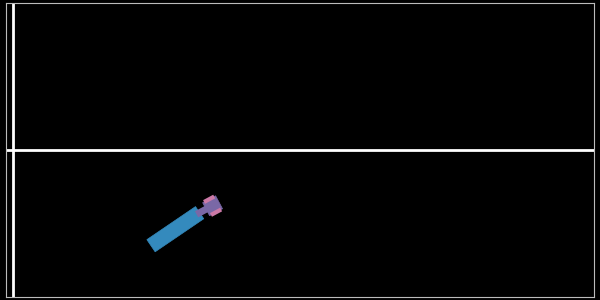

In [4]:
final_lesson = num_lessons + 1
test_controller = torch.load('models/controllers/controller_lesson_{}.pth'.format(final_lesson), weights_only = False)

truck = Truck(lesson = final_lesson, display = True)
truck.reset()

In [ ]:
with torch.no_grad():
    truck.reset()
    i = 0
    while truck.valid():
        t1 = torch.tensor([truck.ϕ],dtype=torch.float32)
        state = truck.state()      
        t2 = torch.Tensor(state)
        state = torch.cat((t1,t2))
        ϕ = test_controller(state)
        truck.step(ϕ.item())
        truck.draw()
        i += 1
    print("Number of Steps: {}".format(i))